In [3]:
#General stuff
import time
import datetime
import glob
import re
import pandas as pd
from collections import Counter
import progressbar
import jellyfish
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import statsmodels.formula.api as smf
from collections import Counter
from itertools import chain

## Pulling in all the files

In [4]:
df = pd.read_csv('data/df_final_harm.csv')

## I want to look for repetitions "sozialrechtliche Abteilungen"
And I'm working with the years, as the whole long string consisting of 15'000 verdicts is just too long. The Kernel dies regularly. Which really isn't much fun.

In [5]:
df_sozrecht = df[df['recht_harm'] == 'Strafrecht']
sozrecht = df_sozrecht[df_sozrecht['Language'] == 'De']['Text-Nummer']

Splitting up the lists.

In [6]:
l = list(sozrecht)
n = 1000
txt_lsts = [l[i:i + n] for i in range(0, len(l), n)]

In [7]:
df_ = pd.DataFrame(columns=['index', 0])
bar = progressbar.ProgressBar()

for txt_lst, i in zip(txt_lsts, bar(range(len(txt_lsts)))):

    long_str = ''
    
    for txt in txt_lst:
    
        file = open('txt_files/' + txt, 'r')
        text = file.read()
        #Making sure the line breaks '/n', 'xa0' and double spaces are removed
        text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', ' ')
        #Removing these automated notifications
        text = text.replace('Wichtiger Hinweis:Diese Website wird in älteren Versionen von Netscape ohne graphische Elemente dargestellt. Die Funktionalität der Website ist aber trotzdem gewährleistet. Wenn Sie diese Website regelmässig benutzen, empfehlen wir Ihnen, auf Ihrem Computer einen aktuellen Browser zu installieren.Zurück zur Einstiegsseite Drucken Grössere Schrift', '')
        text = text.replace('Vorwärts ähnliche Leitentscheide suchenähnliche Urteile ab 2000 suchen Drucken nach oben', '')
        text = text.replace('Bundesgericht Tribunal fédéral Tribunale federale Tribunal federal', '')
        text = text.replace('Navigation Neue Suche Zurück zum Suchresultat Rang: Zurück 180', '')
        text = text.replace('Navigation Neue Suche Zurück zum Suchresultat Rang:1 ähnliche Leitentscheide suchenähnliche Urteile ab 2000 suchen Drucken nach oben', '')
    
        long_str = long_str + text
        
    df_new = pd.DataFrame(pd.Series( long_str[ix:ix+500] for ix in list(range(len(long_str))) ).value_counts()).reset_index()
    df_new = df_new[df_new[0]> 1]
    
    frames = [df_, df_new]
    df_ = pd.concat(frames)
    

 85% (6 of 7) |########################    | Elapsed Time: 0:05:06 ETA: 0:00:51

# Renaming columns
Later, I can just jump to this step, I don't need to repeat the steps above

In [8]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1222616 entries, 0 to 192449
Data columns (total 2 columns):
index    1222616 non-null object
0        1222616 non-null float64
dtypes: float64(1), object(1)
memory usage: 28.0+ MB


In [9]:
df_.columns = [['String', 'Count']]

# Deleting Duplicates

In [10]:
df_ = df_.drop_duplicates(subset='String', keep='first')

In [11]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153869 entries, 0 to 192449
Data columns (total 2 columns):
String    1153869 non-null object
Count     1153869 non-null float64
dtypes: float64(1), object(1)
memory usage: 26.4+ MB


In [12]:
df = df_[df_['Count'] >= 10]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5886 entries, 0 to 449
Data columns (total 2 columns):
String    5886 non-null object
Count     5886 non-null float64
dtypes: float64(1), object(1)
memory usage: 138.0+ KB


# Matching similar Strings
Using Jellyfish and remodelling the original df, using it to create a new list of string. Because these ones are the ones I don't need to consider anymore.

In [14]:
df_new = pd.DataFrame(columns=['String', 'Count', 'Jaro'])

for count in range(1000):
    
    print(count)
    string_list = list(df['String'])
    value_list = []
    bar = progressbar.ProgressBar()

    for elem, i in zip(string_list, bar(range(len(string_list)))):
    
        value = jellyfish.jaro_distance(string_list[0], elem)
        value_list.append(value)
    
    df['Jaro'] = value_list
    df_unique = df[df['Jaro'] >= .825].head(1)

    frames = [df_new, df_unique]
    df_new = pd.concat(frames)

    df = df[df['Jaro'] <= .825]
    del df['Jaro']

 11% (671 of 5886) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:00

0


 98% (5812 of 5886) |##################### | Elapsed Time: 0:00:01 ETA: 0:00:00/Users/barneyjs/.virtualenvs/master/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
 16% (955 of 5802) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

1


 16% (944 of 5731) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

2


 18% (1081 of 5693) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

3


 18% (1077 of 5672) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

4


 17% (1005 of 5667) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

5


 17% (996 of 5617) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

6


 20% (1131 of 5583) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

7


 18% (1042 of 5485) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

8


 19% (1026 of 5400) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

9


 19% (1022 of 5378) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

10


 15% (810 of 5331) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

11


 20% (1073 of 5295) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

12


 22% (1204 of 5284) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

13


 22% (1183 of 5192) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

14


 19% (979 of 5151) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

15


 21% (1100 of 5110) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

16


 21% (1097 of 5096) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

17


 20% (1029 of 5077) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

18


 18% (961 of 5058) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

19


 22% (1150 of 5043) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

20


 18% (949 of 4996) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

21


 19% (941 of 4951) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

22


 20% (999 of 4932) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

23


 21% (1054 of 4894) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

24


 20% (978 of 4826) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

25


 21% (1035 of 4806) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

26


 18% (908 of 4782) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

27


 22% (1088 of 4772) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

28


 22% (1080 of 4740) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

29


 18% (893 of 4702) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

30


 22% (1067 of 4681) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

31


 22% (1055 of 4628) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

32


 22% (1047 of 4594) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

33


 20% (926 of 4568) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

34


 21% (973 of 4518) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

35


 22% (1018 of 4467) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

36


 25% (1125 of 4443) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

37


 20% (889 of 4385) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

38


 24% (1040 of 4323) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

39


 25% (1069 of 4220) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

40


 22% (952 of 4177) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

41


 26% (1100 of 4136) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

42


 21% (880 of 4085) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

43


 24% (977 of 4060) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

44


 21% (864 of 4012) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

45


 22% (901 of 3953) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

46


 21% (841 of 3905) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

47


 22% (883 of 3874) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

48


 24% (927 of 3854) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

49


 25% (966 of 3814) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

50


 27% (1062 of 3810) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

51


 26% (1008 of 3790) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

52


 24% (902 of 3747) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

53


 27% (1041 of 3735) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

54


 26% (989 of 3719) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

55


 29% (1083 of 3717) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

56


 24% (894 of 3714) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

57


 25% (940 of 3712) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

58


 21% (799 of 3711) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

59


 25% (939 of 3707) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

60


 25% (931 of 3676) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

61


 29% (1056 of 3626) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

62


 22% (824 of 3614) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

63


 21% (774 of 3593) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

64


 22% (809 of 3547) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

65


 31% (1110 of 3507) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

66


 29% (1008 of 3460) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

67


 27% (960 of 3444) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

68


 30% (1046 of 3441) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

69


 26% (915 of 3440) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

70


 29% (994 of 3414) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

71


 30% (1030 of 3390) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

72


 27% (943 of 3386) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

73


 27% (940 of 3375) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

74


 29% (961 of 3300) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

75


 25% (832 of 3283) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

76


 31% (1022 of 3227) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

77


 29% (936 of 3212) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

78


 31% (1005 of 3173) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

79


 34% (1077 of 3151) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

80


 31% (996 of 3145) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

81


 31% (968 of 3057) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

82


 32% (1005 of 3053) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

83


 27% (848 of 3042) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

84


 32% (993 of 3016) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

85


 34% (1030 of 3012) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

86


 24% (712 of 2958) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

87


 31% (933 of 2948) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

88


 35% (1032 of 2911) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

89


 36% (1062 of 2893) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

90


 36% (1049 of 2856) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

91


 38% (1066 of 2805) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

92


 36% (1017 of 2770) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

93


 37% (1051 of 2767) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

94


 39% (1084 of 2762) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

95


 37% (1035 of 2724) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

96


 35% (948 of 2672) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

97


 39% (1046 of 2664) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

98


 40% (1079 of 2663) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

99


 41% (1099 of 2629) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

100


 41% (1069 of 2557) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

101


 40% (1005 of 2480) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

102


 43% (1065 of 2473) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

103


 40% (1001 of 2470) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

104


 41% (1031 of 2467) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

105


 43% (1061 of 2464) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

106


 45% (1075 of 2357) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

107


 44% (1035 of 2334) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

108


 39% (905 of 2305) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

109


 45% (1021 of 2239) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

110


 46% (998 of 2130) |##########             | Elapsed Time: 0:00:00 ETA: 0:00:00

111


 49% (1045 of 2115) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

112


 46% (977 of 2084) |##########             | Elapsed Time: 0:00:00 ETA: 0:00:00

113


 49% (1005 of 2034) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

114


 48% (973 of 2022) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

115


 49% (996 of 2017) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

116


 49% (996 of 2016) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

117


 50% (984 of 1943) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

118


 50% (969 of 1912) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

119


 54% (1012 of 1858) |###########           | Elapsed Time: 0:00:00 ETA: 0:00:00

120


 58% (1026 of 1761) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

121


 63% (1088 of 1718) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

122


 59% (992 of 1666) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

123


 65% (1064 of 1616) |##############        | Elapsed Time: 0:00:00 ETA: 0:00:00

124


 64% (997 of 1544) |##############         | Elapsed Time: 0:00:00 ETA: 0:00:00

125


 67% (1029 of 1533) |##############        | Elapsed Time: 0:00:00 ETA: 0:00:00

126


 69% (1051 of 1509) |###############       | Elapsed Time: 0:00:00 ETA: 0:00:00

127


 67% (989 of 1473) |###############        | Elapsed Time: 0:00:00 ETA: 0:00:00

128


 72% (1034 of 1432) |###############       | Elapsed Time: 0:00:00 ETA: 0:00:00

129


 69% (990 of 1421) |################       | Elapsed Time: 0:00:00 ETA: 0:00:00

130


 68% (970 of 1419) |###############        | Elapsed Time: 0:00:00 ETA: 0:00:00

131


 65% (920 of 1397) |###############        | Elapsed Time: 0:00:00 ETA: 0:00:00

132


 77% (1078 of 1396) |################      | Elapsed Time: 0:00:00 ETA: 0:00:00

133


 77% (1019 of 1319) |################      | Elapsed Time: 0:00:00 ETA: 0:00:00

134


 82% (1014 of 1232) |##################    | Elapsed Time: 0:00:00 ETA: 0:00:00

135


 82% (952 of 1156) |##################     | Elapsed Time: 0:00:00 ETA: 0:00:00

136


 91% (1006 of 1103) |####################  | Elapsed Time: 0:00:00 ETA: 0:00:00

137


 92% (993 of 1074) |#####################  | Elapsed Time: 0:00:00 ETA: 0:00:00

138


 94% (975 of 1027) |#####################  | Elapsed Time: 0:00:00 ETA: 0:00:00

139


 87% (890 of 1018) |####################   | Elapsed Time: 0:00:00 ETA: 0:00:00

140


 87% (826 of 945) |####################    | Elapsed Time: 0:00:00 ETA: 0:00:00

141


 70% (668 of 941) |#################       | Elapsed Time: 0:00:00 ETA: 0:00:00

142


 84% (794 of 936) |####################    | Elapsed Time: 0:00:00 ETA: 0:00:00

143


 94% (873 of 919) |######################  | Elapsed Time: 0:00:00 ETA: 0:00:00

144


 86% (786 of 912) |####################    | Elapsed Time: 0:00:00 ETA: 0:00:00

145


N/A% (0 of 817) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

146
147


N/A% (0 of 716) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

148
149


N/A% (0 of 670) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

150
151


 59% (366 of 614) |#############          | Elapsed Time: 0:00:00 ETA:  0:00:00

152
153


 70% (366 of 516) |################       | Elapsed Time: 0:00:00 ETA:  0:00:00

154
155


 88% (377 of 425) |####################   | Elapsed Time: 0:00:00 ETA:  0:00:00

156
157


N/A% (0 of 223) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

158
159
160


N/A% (0 of 146) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

161
162
163


N/A% (0 of 68) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

164
165
166
167


N/A% (0 of 23) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417


# Cleaning the New DF and Creating a String

In [15]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 287
Data columns (total 3 columns):
String    172 non-null object
Count     172 non-null float64
Jaro      172 non-null float64
dtypes: float64(2), object(1)
memory usage: 5.4+ KB


In [16]:
del df_new['Count']

In [17]:
del df_new['Jaro']

In [18]:
len(list(df_new['String']))

172

In [19]:
string_list = list(df_new['String'])

# Iterating through all the files

Functions to pull out relevant information

In [20]:
REGEXES_SCHREIBER = [
    r'[gG]reffier\s*:*\s*\w*\.*\s*\w*',
    r'[Gg]reffière\s*:*\s*\w*\.*\s*\w*',
    r'[gG]erichtsschreiberi*n*\s*:* \w*\.*\s*\w*',
    r'[Cc]ancelliere*n*\s*:* \w*\.*\s*\w*']

In [21]:
def gerichtsschreiber(doc):
    try:
        text = next(chain.from_iterable(re.finditer(r, doc) for r in REGEXES_SCHREIBER), None)
        return text.group()
    except:
        None

In [22]:
def extracting_date(doc):
    Datum = re.findall(r"[0-9]+\.[0-9]+\.20[0-9]+", doc)
    try:
        return Datum[0]
    except:
        pass

In [23]:
def extracting_akten_nummer(doc):
    an = re.findall(r"[0-9]*[A-Z][.]*[_]*[ ]*[0-9]+/[0-9]+", doc)
    try:
        an = an[0]
        an = an.replace('_', ' ')
        return an
    except:
        pass

In [24]:
l = list(sozrecht)

In [25]:
txt_elems = []
bar = progressbar.ProgressBar()

for text_file, i in zip(l, bar((range(len(l))))):
    
    file = open('txt_files/' + text_file, 'r')
    text = file.read()
    file.close()
    
    #Special formatting
    text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', '')
    text = text.replace('  ', ' ')
    
    Datum = extracting_date(text)
    Aktennummer = extracting_akten_nummer(text)
    Gerichtsschreiber = gerichtsschreiber(text)
    
    
    if string_list[0] in text:
        boolean = 1
    else:
        boolean = 0
    
    mini_dict = {'Text Nummer': text_file,
                 'Datum': Datum,
                 string_list[0][:20]: boolean,
                 'Aktennummer': Aktennummer,
                 'Gerichtsschreiber': Gerichtsschreiber}
    
    txt_elems.append(mini_dict)

 98% (6708 of 6794) |##################### | Elapsed Time: 0:00:10 ETA: 0:00:00

In [26]:
df_bools = pd.DataFrame(txt_elems)

# Repeat what I did above, now attaching the lists to df_bools

In [27]:
bar = progressbar.ProgressBar()

for string, i in zip(string_list, bar(range(len(string_list)))):
    
    bool_list = []
    
    for text_file in l:
    
        file = open('txt_files/' + text_file, 'r')
        text = file.read()
        file.close()
    
        #Special formatting
        text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', '')
        text = text.replace('  ', ' ')
    
        if string in text:
            boolean = 1
        else:
            boolean = 0
        
        bool_list.append(boolean)
    
    df_bools[string[:20]] = bool_list

 99% (171 of 172) |####################### | Elapsed Time: 0:03:09 ETA: 0:00:01

In [28]:
df_bools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6794 entries, 0 to 6793
Columns: 175 entries, Aktennummer to das bisherige Verfah
dtypes: int64(171), object(4)
memory usage: 9.1+ MB


In [29]:
df_bools.to_csv('bools_text_snippets_de_straf.csv')

In [30]:
df_bools = pd.read_csv('bools_text_snippets_de_straf.csv')

In [31]:
del df_bools['Unnamed: 0']

# Making Total Column

In [32]:
df_bools['TOTAL'] = df_bools.sum(axis=1, numeric_only=True)

In [33]:
df_bools['TOTAL'].describe()

count    6794.000000
mean        0.377686
std         2.182221
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        36.000000
Name: TOTAL, dtype: float64

# Dates

In [34]:
df_bools['Datetime'] = pd.to_datetime(df_bools['Datum'], format="%d.%m.%Y")
df_bools.index = df_bools['Datetime']

# Plotting and Linear Regression

In [114]:
df_counts_pyear = pd.DataFrame(df_bools.resample('A')['TOTAL'].sum()).reset_index()

In [115]:
def change(elem):
    elem = str(elem)
    elem = int(elem.replace('-12-31 00:00:00', ''))
    return elem

In [116]:
df_counts_pyear

,Datetime,TOTAL
0,2007-12-31,80
1,2008-12-31,295
2,2009-12-31,669
3,2010-12-31,107
4,2011-12-31,80
5,2012-12-31,70
6,2013-12-31,292
7,2014-12-31,249
8,2015-12-31,608
9,2016-12-31,71


In [117]:
df_counts_pyear['Years'] = df_counts_pyear['Datetime'].apply(change)

In [118]:
lm = smf.ols(formula="TOTAL~Years",data=df_counts_pyear).fit()

In [119]:
lm.params

Intercept    14097.781818
Years           -6.890909
dtype: float64

In [120]:
intercept, slope = lm.params

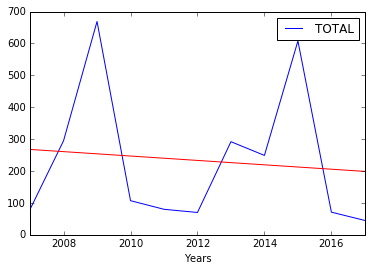

In [121]:
df_counts_pyear.plot(x="Years",y="TOTAL")
plt.plot(df_counts_pyear["Years"],slope*df_counts_pyear["Years"]+intercept,"-",color="red") 

# Without 2017

In [122]:
df_2007_2016 = df_counts_pyear[df_counts_pyear['Years'] != 2017]

In [123]:
lm = smf.ols(formula="TOTAL~Years",data=df_2007_2016).fit()

In [124]:
lm.params

Intercept   -6513.854545
Years           3.363636
dtype: float64

In [125]:
intercept, slope = lm.params

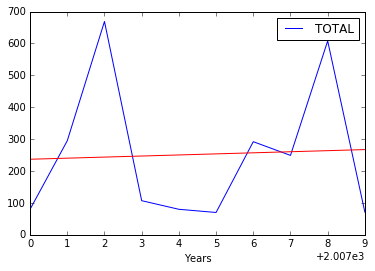

In [126]:
df_2007_2016.plot(x="Years",y="TOTAL")
plt.plot(df_2007_2016["Years"],slope*df_2007_2016["Years"]+intercept,"-",color="red")

In [127]:
df_2007_2016.to_csv('2007_2016_straf_de.csv')

# Harmonising at Gerichtsschreiber

In [128]:
def harm(elem):
    try:
        elem = elem.replace('R.', 'R')
        elem = elem.split('.')[0].replace('Gerichtsschreiber ', '').replace('Gerichtsschreiberin ', '')
        return elem
    except:
        return elem

In [129]:
df_bools['Schreiberharm'] = df_bools['Gerichtsschreiber'].apply(harm)

In [130]:
df_bools['Schreiberharm'].value_counts().head()

C               1440
Arquint Hill     911
Monn             701
Unseld           325
Briw             307
Name: Schreiberharm, dtype: int64

# Merging with large file to sort out Abgeschrieben/Nichteingetreten

In [131]:
df = pd.read_csv('data/df_final_harm.csv')
df = df[['Aktennummer', 'Entscheid_harm']].copy()
df_ = df_bools.merge(df, left_on='Aktennummer', right_on='Aktennummer')
df_ = df_[df_['Entscheid_harm'] != 'Nicht eingetreten']

# Working out, total by Clerk

In [132]:
df_totalelems = pd.DataFrame(df_.groupby('Schreiberharm')['TOTAL'].sum().sort_values(ascending=False))

# Working out number of appeals, we counted their involvement in

In [133]:
df = pd.read_csv('data/df_final_harm.csv')
df = df[df['Entscheid_harm'] != 'Nicht eingetreten']
df_sozrecht = df[df['recht_harm'] == 'Strafrecht']
df_sozrecht = df_sozrecht[df_sozrecht['Language'] == 'De']

In [134]:
df_totalappeals = pd.DataFrame(df_sozrecht['Schreiber_harm'].value_counts())

# Merging total Elem Count with total Appeals by Clerk

In [135]:
df_final = df_totalelems.merge(df_totalappeals, how='left', left_index=True, right_index=True)

In [136]:
df_final.columns = [['ELEM 500 COUNT', 'TOTAL APPEALS']]
df_final['Elem pCase'] = round(df_final['ELEM 500 COUNT'] / df_final['TOTAL APPEALS'], 1)

In [137]:
df_final.sort_values(by='Elem pCase', ascending=False).head(30)

,ELEM 500 COUNT,TOTAL APPEALS,Elem pCase
Schreiberharm,,,
Stohner,862,200.0,4.3
Moses,317,124.0,2.6
Keller,293,199.0,1.5
Hofer,7,7.0,1.0
Boog,181,258.0,0.7
Faga,159,257.0,0.6
Binz,80,154.0,0.5
Kratz,14,28.0,0.5
Unseld,107,284.0,0.4


# Gutheissungsquote nach Gerichtsschreiber

In [138]:
df_gut = pd.read_csv('data/schreiber_percent.csv')

In [139]:
df_gut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
Unnamed: 0             250 non-null int64
Abgewiesen %           250 non-null float64
Gutgeheissen %         250 non-null float64
Nicht eingetreten %    250 non-null float64
Schreiber              250 non-null object
Total                  250 non-null int64
dtypes: float64(3), int64(2), object(1)
memory usage: 11.8+ KB


In [140]:
df_gut = df_gut[['Schreiber', 'Gutgeheissen %']].copy()
def remove(elem):
    elem = elem.replace('.', '')
    return elem
df_gut['Schreiber'] = df_gut['Schreiber'].apply(remove)
df_gut.index = df_gut['Schreiber']
del df_gut['Schreiber']

# Merge with final df

In [142]:
df_final = df_final.merge(df_gut, how='left', left_index=True, right_index=True)

In [143]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, Stohner to Adamczyk
Data columns (total 4 columns):
ELEM 500 COUNT    42 non-null int64
TOTAL APPEALS     37 non-null float64
Elem pCase        37 non-null float64
Gutgeheissen %    36 non-null float64
dtypes: float64(3), int64(1)
memory usage: 1.6+ KB


In [144]:
df_final.sort_values(by='Elem pCase', ascending=False).head(50)
df_final = df_final[df_final['TOTAL APPEALS'] > 50]

In [145]:
df_final.drop('Monn', inplace=True)
df_final.drop('Arquint Hill', inplace=True)

In [146]:
df_final.columns = [['ELEM 500 COUNT', 'TOTAL APPEALS', 'ElempCase', 'Gutgeheissen']]

# Is there a correlation between amout of copy pasted elements and the percentage of successful appeals?

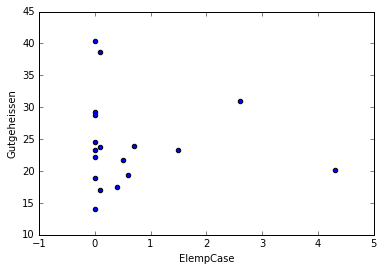

In [147]:
df_final.plot(kind='scatter', x='ElempCase', y='Gutgeheissen')

In [148]:
lm = smf.ols(formula="ElempCase~Gutgeheissen",data=df_final).fit()

In [149]:
intercept, slope = lm.params

In [150]:
lm.params

Intercept       0.854992
Gutgeheissen   -0.010253
dtype: float64

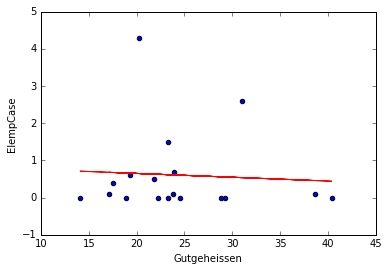

In [151]:
df_final.plot(kind='scatter', x="Gutgeheissen",y="ElempCase")
plt.plot(df_final["Gutgeheissen"],slope*df_final["Gutgeheissen"]+intercept,"-",color="red") 

In [152]:
df_final

,ELEM 500 COUNT,TOTAL APPEALS,ElempCase,Gutgeheissen
Schreiberharm,,,,
Stohner,862,200.0,4.3,20.2
Moses,317,124.0,2.6,31.0
Keller,293,199.0,1.5,23.3
Boog,181,258.0,0.7,23.9
Faga,159,257.0,0.6,19.3
Unseld,107,284.0,0.4,17.5
Binz,80,154.0,0.5,21.8
Pasquini,9,188.0,0.0,23.3
Held,8,145.0,0.1,38.6


In [153]:
df_final.to_csv('straf_500_de.csv')

In [ ]:
# Merge with french Data